+ import useful libraries

In [3]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import sys

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

ModuleNotFoundError: No module named 'geopandas'

In [3]:
import scipy as sp
import plotly as ply

In [4]:
import chart_studio.plotly as py

+ Get the list of plant symbols.  The csv file below was downloaded from https://plants.usda.gov/home/downloads, From the state plant list for Illinois.

In [5]:
plup = pd.read_csv("D:/qgis/usda_plant_symbols.csv")

We want to lookup the usda sysmbol for a plant (which is the key to data on the nrcs website  )  but the scientific names here are appended with an author, so we get the first to words of the "Scientific Name with Author" field

In [6]:
plup["SciName"] =plup.apply(lambda r: " ".join(r['Scientific Name with Author'].split()[:2]), axis=1)  
plu = plup.drop_duplicates(subset=["SciName"]).set_index('SciName')

The spreadsheet below was created from the query
>`Query quality_grade=research&identifications=any&iconic_taxa[]=Plantae&place_id=159205&d1=2017-05-01&d2=2022-05-17
Columns id, observed_on_string, observed_on, quality_grade, description, num_identification_agreements, num_identification_disagreements, oauth_application_id, place_guess, latitude, longitude, positioning_device, species_guess, scientific_name, common_name, iconic_taxon_name, taxon_id`

Run on [https://www.inaturalist.org/observations/export]
The place id seems to refer to all DupageForest Preserve property, so this immediately reduces the list of observations to places we are interested in

With a little work this data could be requested throught the api

The spreadsheet is de-duped on species.  we only want to lookup the species once on wildflower.org to find the "interesting" plants for pollinator habitat

Copy the "scientific_name" column into "SciName" so it will match  plant lookup data, then get the usda symbol for the plant

In [7]:
dfp_flora = pd.read_excel("inat_species_5yrs.xlsx")
dfp_flora["SciName"] = dfp_flora["scientific_name"]

In [8]:
lookup_list = dfp_flora.join(plu, on="SciName").set_index("SciName")

wildflower.org  wont return the plant page unles the "User-Agent" header is set.  not sure if it cares what it is set to.  just copied the header from a browser

In [9]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

Get the page for the plant whose symbol is "sn", and read it into beautiful soup for parsing

In [10]:
def get_lb_page_for_sci_name(sn):
    symbol = lookup_list.loc[[sn]]["Symbol"].values[0]
    url_template = f"https://www.wildflower.org/plants/result.php?id_plant={symbol}"
    #print(url_template)
    res = requests.get(url_template, headers=headers)
    if res.status_code != 200:
        sys.exit("page request failed")
    soup = BeautifulSoup(res.text, 'lxml')
    return (soup, sn, symbol)
 

Parse the desired data out of the soup object.  We look for 
- Bloom time
- Special Value to Native Bees 
- Special Value to Bumble Bees
- Nectar Source
- Larval Host:

And create a record for the plant

In [27]:
def get_lb_data_from_soup(soup, sn, symbol):
    #print('Getting Lady Bird data from soup')
    rec = {"SciName": sn, 
           "Symbol": symbol, 
           "Bloom Time:": " ",
           "Jan": 0,
           "Feb": 0,
           "Mar": 0,
           "Apr": 0,
           "May": 0,
           "Jun": 0,
           "Jul": 0,
           "Aug": 0,
           "Sep": 0,
           "Oct": 0,
           "Nov": 0,
           "Dec": 0,
           "Special Value to Native Bees": 0 ,
           "Special Value to Bumble Bees": 0, 
           "Nectar Source:": 0, 
           "Larval Host:": "No",
           "Larval Host(Monarch)": 0,
           "Larval Host(Other)": 0}
    h4s = soup.find_all("h4")
    #print("h4's found: ",h4s)
    for n in h4s:
        #print('\n\n', '####', n, n.string)
        if n.string == "Bloom Information":
            #print("Found Bloom Information")
            sibs = n.find_next_siblings()
            for s in sibs:
                #print(s)
                if s.string == "Bloom Time:":
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    mos = s.next_sibling.split(",")
                    for m in mos:
                        rec[m.strip()] = 1                    
                    rec[s.string] = s.next_sibling
        if n.string == "Benefit":
            sibs = n.find_next_siblings()
            for s in sibs:
                #print(s)
                if s.string == "Nectar Source:":
                    print("found benefit for ", sn, symbol)
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    rec[s.string] = 1
                if s.string == "Larval Host:":
                    print("found benefit for ", sn, symbol)
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    rec[s.string] = s.next_sibling
                    if "onarch" in s.next_sibling:
                        rec["Larval Host(Monarch)"] = 1
                    else: 
                        rec["Larval Host(Other)"] = 1
        if n.string == "Value to Beneficial Insects":
            #print(n.parent.prettify())
            for s in n.find_next_siblings():
                #print(s)
                if s.string: 
                    if (s.string.strip().startswith("Special") and (s.string.find("Honey") == -1)):
                        #print('adding string', s)
                        rec[s.string.replace("\xa0", " ")] = 1
                #print(s.next_sibling)
                if (str(s.next_sibling).strip().startswith("Special") and (str(s.next_sibling).find("Honey") == -1)):
                    #print("adding next sibling", s.next_sibling)
                    rec[str(s.next_sibling.strip().replace("\xa0", " "))] = 1                
    return rec

Run the two above functions once for each species reported, and collect the records into a dataframe

In [ ]:
rec_list = []
for plant in dfp_flora.SciName.values:
    #print(plant)
    page, sn, symbol = get_lb_page_for_sci_name(plant)
    rec_list.append(get_lb_data_from_soup(page, sn, symbol))


In [31]:
df = pd.DataFrame(rec_list)

Save the species information to an Excel sheet

In [32]:
df.to_excel("G:/My Drive/JupyterNotebooks/LadyBirdData_iNaturalist_expanded.xlsx")

Now get all the observations (and create the "SciName" column)

In [34]:
obs = pd.read_csv("G:/My Drive/JupyterNotebooks/inat_obs_5yrs.csv")
obs["SciName"] = obs.scientific_name

add plant information to the observation record, and get the records of observations of "interesting plants"

In [36]:
oo = obs.join(df.reset_index().set_index("SciName"), on="SciName")
#oo["Interesting?"] = oo.apply(lambda r: (r["Special Value to Native Bees"] == "Yes") | (r["Special Value to Bumble Bees"] == "Yes") | (r["Nectar Source:"] == "yes") | (r["Larval Host:"] != "No"), axis = 1) 
#int_df = oo[oo["Interesting?"]]

In [53]:
oo["habitat_index"] = (oo["Special Value to Native Bees"] 
     + oo["Special Value to Bumble Bees"] 
     + oo["Nectar Source:"] 
     + oo["Larval Host(Monarch)"] 
     + oo["Larval Host(Other)"])
oo["# months with blooms"] = (oo["Jan"] + oo["Feb"] + oo["Mar"] + oo["Apr"] 
     + oo["May"] + oo["Jun"] + oo["Jul"] + oo["Aug"] + oo["Sep"] 
     + oo["Oct"] + oo["Nov"] + oo["Dec"] )
int_df = oo[oo.habitat_index > 0]

Now get the gis information on where the EcoUnits are into a geopandas dataframe

In [54]:
# Open the shapefile
ecoUnits = gpd.GeoDataFrame.from_file('D:/QGIS/Eco Unit Shapefile/')

make a geodataframe from the observations list (the inat has lat/long of observation)
Make  the coordinate reference systems match

In [55]:
gdf_inats = gpd.GeoDataFrame(int_df,
    geometry=gpd.points_from_xy(int_df.longitude, int_df.latitude))
gdf_inats = gdf_inats.set_crs(crs="EPSG:4326")

In [56]:
eco_lats = ecoUnits.to_crs("EPSG:4326")

Do a spatial join to match each observation to the EUnit it was made in.  Drop multilple observations of the same plant in the same EUnit

In [57]:
mdf = eco_lats.sjoin(gdf_inats, how="left", predicate="contains").sort_values("EUnit")

mdf = mdf[mdf.habitat_index > 0]  # Should be unnecessary, we already filterd to "Interesting?"
mdf = mdf.drop_duplicates(subset=["EUnit", "Symbol"])

Save the data to excel

In [58]:
mdf.to_excel("inat_interesting_units.xlsx")

In [38]:
oo.columns

Index(['PresName', 'EcosUnit', 'EcosName', 'GenType', 'CommType', 'CommName',
       'SciName', 'Year', 'UnitArea', 'index', 'Symbol', 'Bloom Time:',
       'Special Value to Native Bees', 'Special Value to Bumble Bees',
       'Nectar Source:', 'Larval Host:', 'Special Value to Honey Bees',
       'Interesting?'],
      dtype='object')

In [42]:
pd.options.display.float_format = '{:,.2f}'.format

In [169]:
agg_df = (oo.groupby(["PresName", "EcosUnit", "GenType", "CommType", "UnitArea", "CommName", "SciName", "Bloom Time:",
             "Special Value to Native Bees", "Special Value to Bumble Bees", "Nectar Source:", "Larval Host:", "Year", "Interesting?"])
     .count().drop(columns=["EcosName","index", "Symbol", "Special Value to Honey Bees"]))


In [171]:
agg_df.to_excel("G:/My Drive/PlantInfo/ConservationAreaAnalysis.xlsx")

In [136]:
agg_df[agg_df.reset_index()["Special Value to Native Bees"] != ""]

C:\Users\ajc\AppData\Local\conda\conda\envs\anaconda3a\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [201]:
ldf = oo.reset_index()[oo["Interesting?"]].groupby(["EcosUnit", "CommName", "SciName"] ).first()
#.reset_index()["EcosUnit", "CommName", "SciName"]

In [203]:
ldf = ldf.drop(columns=ldf.columns).reset_index()

In [190]:
ldf.groupby("EcosUnit").agg({"CommName": ", ".join, "SciName": ", ".join})

,CommName,SciName
EcosUnit,,
CUMDU,Leafy Lupine,Lupinus polyphyllus
EBE02,Multiflora Rose,Rosa multiflora
EBE05,"Chinese Buckthorn, Multiflora Rose","Rhamnus utilis, Rosa multiflora"
EBE06,"Boxelder, Garlic Mustard, Giant Ragweed, Water...","Acer negundo, Alliaria petiolata, Ambrosia tri..."
EBE07,"Common Dandelion, Creeping Charlie, Hairy Crab...","Taraxacum officinale, Glechoma hederacea, Digi..."
...,...,...
ewa06,Skunk Cabbage,Symplocarpus foetidus
ewc08,"Common Mountain Mint, Cowbane, Illinois Bundle...","Pycnanthemum virginianum, Oxypolis rigidior, D..."
ewd07,"Common Forget-Me-Not, Fen Panicled Sedge, Fen ...","Myosotis scorpioides, Carex prairea, Carex ste..."


In [211]:
ldf.groupby("EcosUnit").agg({"SciName": "count"}).to_excel("G:/My Drive/PlantInfo/PlantCount.xlsx")

In [212]:
ldf.groupby("EcosUnit").agg({"SciName": "count"}).to_csv("G:/My Drive/PlantInfo/PlantCount.csv")

In [90]:
idf = oo[oo["Interesting?"]]

<AxesSubplot:xlabel='UnitArea', ylabel='SciName'>

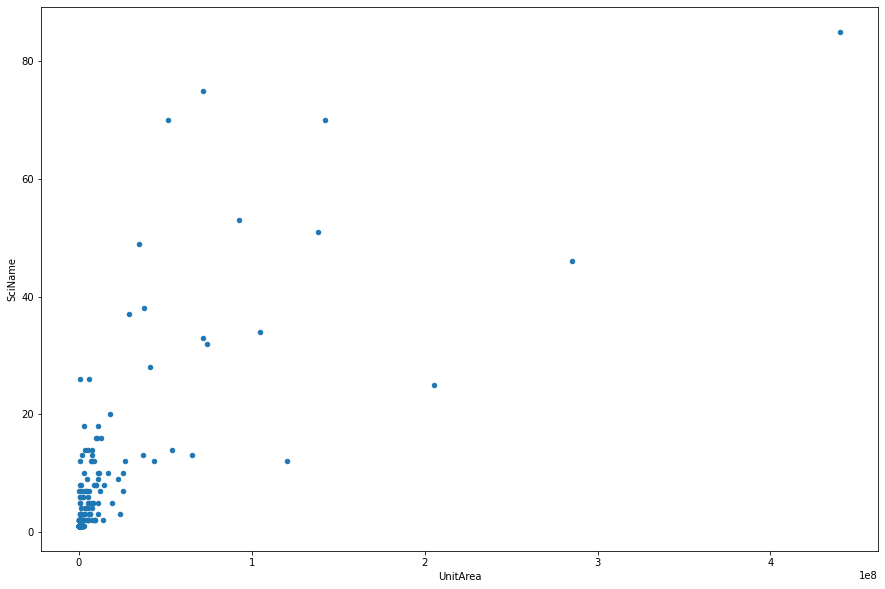

In [95]:
sdf.sort_values("UnitArea").plot.scatter(x="UnitArea", y="SciName", figsize=(15,10))